In [1]:
import urllib
import os 
from sklearn.cluster import KMeans
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import yaml
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Constantes

IMAGE_WIDTH= 224
IMAGE_HEIGHT= 224
IMAGE_CHANNELS= 3
IMAGE_SIZE= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 20

In [3]:
os.getcwd()

'c:\\Users\\danie\\Bootcamp\\Proyectos\\Screening_of_Autism_ML_project_final\\Screening_of_Autism_ML_project_final\\notebooks'

In [4]:
# # Rutas a las carpetas de imágenes
# base_dir = os.getcwd()
# autistic_dir = os.path.join(base_dir, 'autistic')
# non_autistic_dir = os.path.join(base_dir, 'non_autistic')


# image_paths = []
# labels = []

# # Carpeta autistic
# for image_name in os.listdir(autistic_dir):
#     image_paths.append(os.path.join(autistic_dir, image_name))
#     labels.append('autistic')

# # Carpeta non_autistic
# for image_name in os.listdir(non_autistic_dir):
#     image_paths.append(os.path.join(non_autistic_dir, image_name))
#     labels.append('non_autistic')

# # Crear el DataFrame
# df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# df.head()


In [5]:
def create_image_dataframe():
    """
    Esta función crea un DataFrame que contiene las rutas de las imágenes y sus respectivas etiquetas.
    Las imágenes se recogen de las carpetas 'autistic' y 'non_autistic', ubicadas en el directorio actual.
    
    Returns:
        df (pd.DataFrame): DataFrame con dos columnas - 'image_path' y 'label'.
    """
    # Rutas relativas a las carpetas de imágenes
    autistic_dir = 'autistic'
    non_autistic_dir = 'non_autistic'

    image_paths = []
    labels = []

    # Carpeta autistic
    for image_name in os.listdir(autistic_dir):
        image_paths.append(os.path.join(autistic_dir, image_name))
        labels.append('autistic')

    # Carpeta non_autistic
    for image_name in os.listdir(non_autistic_dir):
        image_paths.append(os.path.join(non_autistic_dir, image_name))
        labels.append('non_autistic')

    # Crear el DataFrame
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})

    return df

# Uso de la función
df = create_image_dataframe()
df.head()


,image_path,label
0,autistic\0001.jpg,autistic
1,autistic\0002.jpg,autistic
2,autistic\0003.jpg,autistic
3,autistic\0004.jpg,autistic
4,autistic\0005.jpg,autistic


In [6]:
df.to_csv('./df_raw.csv', index=False)

In [7]:
target_map = {'autistic': 0,
              'non_autistic': 1}

In [8]:
target_map = {'autistic': 0,
              'non_autistic': 1}
df['target'] = df['label'].map(target_map)

In [9]:
df

,image_path,label,target
0,autistic\0001.jpg,autistic,0
1,autistic\0002.jpg,autistic,0
2,autistic\0003.jpg,autistic,0
3,autistic\0004.jpg,autistic,0
4,autistic\0005.jpg,autistic,0
...,...,...,...
2931,non_autistic\1464.jpg,non_autistic,1
2932,non_autistic\1465.jpg,non_autistic,1
2933,non_autistic\1466.jpg,non_autistic,1
2934,non_autistic\1467.jpg,non_autistic,1


In [10]:
ruta_imagen = df.loc[0, 'image_path']

In [11]:
img = cv2.imread(ruta_imagen, 1)
img.shape

(224, 224, 3)

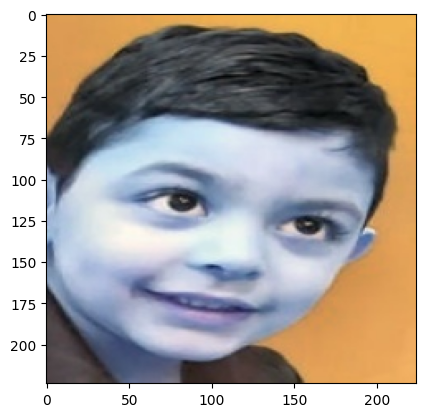

In [12]:
plt.imshow(img)

In [13]:
def prepare_dataframe(df):
    """
    Esta función procesa un DataFrame agregando una columna 'target' mapeada de la columna 'label',
    procesa las imágenes de las rutas dadas en 'image_path' y reorganiza el DataFrame.

    Args:
        df (pd.DataFrame): DataFrame original con columnas 'image_path' y 'label'.

    Returns:
        pd.DataFrame: DataFrame procesado con columnas adicionales 'target' e 'Imagenes'.
    """
    # Mapeo de etiquetas a valores numéricos
    target_map = {'autistic': 0, 'non_autistic': 1}
    df['target'] = df['label'].map(target_map)

    # Función para leer y escalar imágenes
    def procesar_imagen(path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img_scale = np.array(img) / 255.0
        return img_scale

    # Aplicar la función de procesamiento de imágenes
    df['Imagenes'] = df['image_path'].apply(procesar_imagen)

    # Mezclar y reiniciar índice del DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    return df

# Uso de la función
# Asumiendo que df es tu DataFrame original
df_processed = prepare_dataframe(df)


In [14]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2936 non-null   object
 1   label       2936 non-null   object
 2   target      2936 non-null   int64 
 3   Imagenes    2936 non-null   object
dtypes: int64(1), object(3)
memory usage: 91.9+ KB


In [15]:
#Convierto X en un array de numpy
X = np.stack(df_processed['Imagenes'].values)
y = np.array(df_processed['target'])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)


(2348, 224, 224, 3)
(588, 224, 224, 3)
(2348,)
(588,)


##  A continuación voy a entrenar mi primer modelo de CNN, luego lo someteré a experimentación

In [18]:

earlystop = EarlyStopping(patience=5)
mcheckpoint = ModelCheckpoint("callback_model_1.h5")

In [19]:
# layers = [
#     keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    
#     keras.layers.Conv2D(128, (3,3), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    
#     keras.layers.Flatten(),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ]

# model = keras.Sequential(layers)
# model.compile(optimizer='adam',
#                 loss='binary_crossentropy',
#                 metrics=['accuracy']
#                 )

In [20]:
# model.summary()

In [21]:
# history_1 = model.fit(X_train,
#                         y_train,
#                         epochs = EPOCHS,
#                         batch_size = BATCH_SIZE,
#                         callbacks = [earlystop, mcheckpoint],
#                         validation_split = 0.2
    
# )

In [22]:
# results = model.evaluate(X_test, y_test)
# results

In [23]:
# model.predict(X_test).round(0)

In [24]:
# mcheckpoint = ModelCheckpoint("callback_model_2_rgb.h5")
# learning_rate = 0.001 
# optimizer = Adam(learning_rate=learning_rate)


# layers = [
#     keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    
#     keras.layers.Conv2D(128, (3,3), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    
#     keras.layers.Flatten(),
    
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.1),  
    
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.1), 
    
#     keras.layers.Dense(1, activation='sigmoid')
# ]


# model_2 = keras.Sequential(layers)
# model_2.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [25]:
# history_2 = model_2.fit(X_train,
#                         y_train,
#                         epochs = EPOCHS,
#                         batch_size = BATCH_SIZE,
#                         callbacks = [earlystop, mcheckpoint],
#                         validation_split = 0.2
    
# )

In [26]:
# results = model_2.evaluate(X_test, y_test)
# results

In [27]:
# model_2.predict(X_test).round(0)

In [28]:
from tensorflow.keras import regularizers

mcheckpoint = ModelCheckpoint("callback_model_3_rgb.h5")

optimizer = Adam(learning_rate=0.0005)  
layers = [
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1, activation='sigmoid')
]

model_3 = keras.Sequential(layers)
model_3.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])


In [29]:
history_3 = model_3.fit(X_train,
                        y_train,
                        epochs = EPOCHS,
                        batch_size = BATCH_SIZE,
                        callbacks = [earlystop, mcheckpoint],
                        validation_split = 0.2
    
)

Epoch 1/20


59/59 [==============================] - 21s 340ms/step - loss: 1.0142 - accuracy: 0.5410 - val_loss: 0.7720 - val_accuracy: 0.6787
Epoch 2/20
59/59 [==============================] - 20s 334ms/step - loss: 0.7656 - accuracy: 0.6177 - val_loss: 0.7438 - val_accuracy: 0.7149
Epoch 3/20
59/59 [==============================] - 20s 332ms/step - loss: 0.7432 - accuracy: 0.6512 - val_loss: 0.7078 - val_accuracy: 0.7191
Epoch 4/20
59/59 [==============================] - 19s 313ms/step - loss: 0.7049 - accuracy: 0.6715 - val_loss: 0.6557 - val_accuracy: 0.7489
Epoch 5/20
59/59 [==============================] - 18s 307ms/step - loss: 0.6764 - accuracy: 0.7034 - val_loss: 0.6556 - val_accuracy: 0.7255
Epoch 6/20
59/59 [==============================] - 19s 315ms/step - loss: 0.6521 - accuracy: 0.7173 - val_loss: 0.6714 - val_accuracy: 0.7000
Epoch 7/20
59/59 [==============================] - 19s 314ms/step - loss: 0.6294 - accuracy: 0.7460 - val_loss: 0.6489 - val_accuracy: 0.72

In [39]:
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

In [40]:
best_epoch = val_loss.index(min(val_loss)) + 1

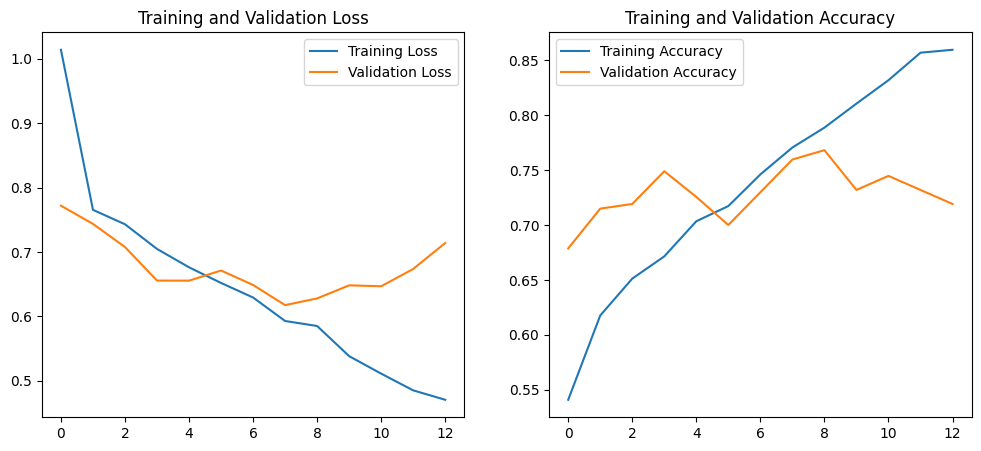

In [45]:
# Acceder a los datos del historial
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
accuracy = history_3.history['accuracy']  # Cambia 'accuracy' por la métrica que usaste
val_accuracy = history_3.history['val_accuracy']  # Ídem

# Crear gráficos para pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [43]:
# import pickle

# # Suponiendo que 'history' es el retorno de model.fit()
# with open('model_history.pkl', 'wb') as file:
#     pickle.dump(history_3.history, file)


In [30]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [31]:
results = model_3.evaluate(X_test, y_test)
results

19/19 [==============================] - 1s 58ms/step - loss: 0.6687 - accuracy: 0.7449


[0.6687327027320862, 0.7448979616165161]

In [32]:
predicciones_probabilidades = model_3.predict(X_test)
predicciones = (predicciones_probabilidades > 0.5).astype("int32").squeeze()

19/19 [==============================] - 1s 55ms/step


In [33]:
indices_incorrectos = np.where(predicciones != y_test)[0]

In [34]:
%matplotlib inline

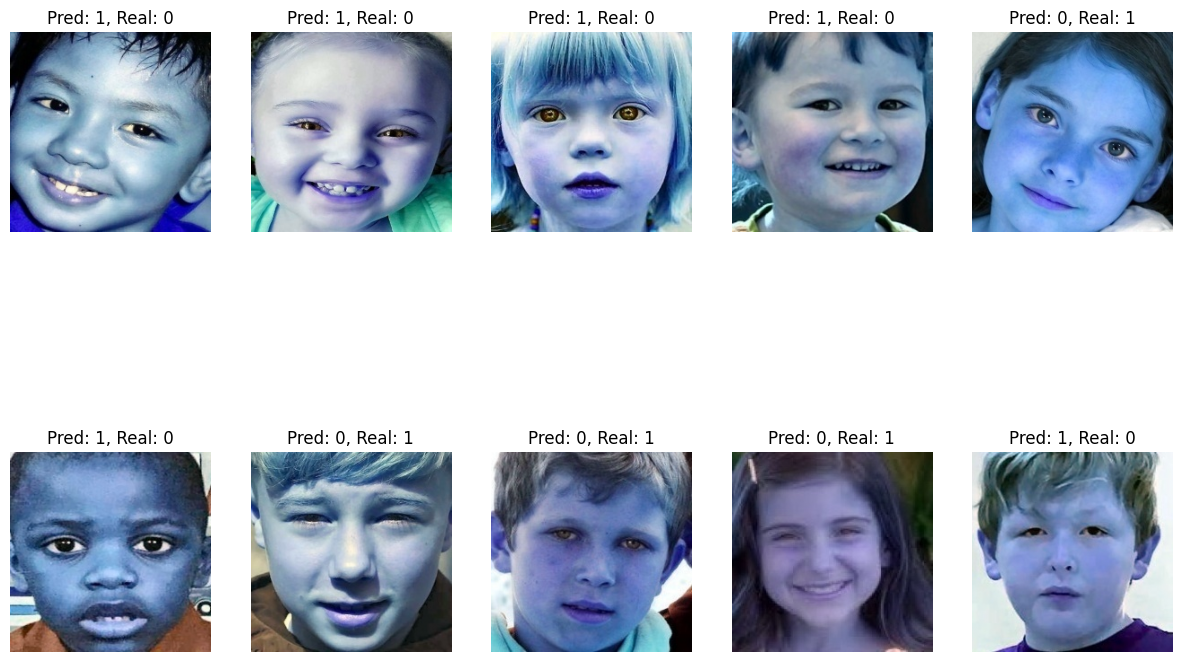

In [35]:
num_imagenes = 10
plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices_incorrectos[:num_imagenes]):
    img = X_test[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)  # Mostrar la imagen directamente sin convertir a RGB
    plt.title(f"Pred: {predicciones[idx]}, Real: {y_test[idx]}")
    plt.axis('off')

plt.show()

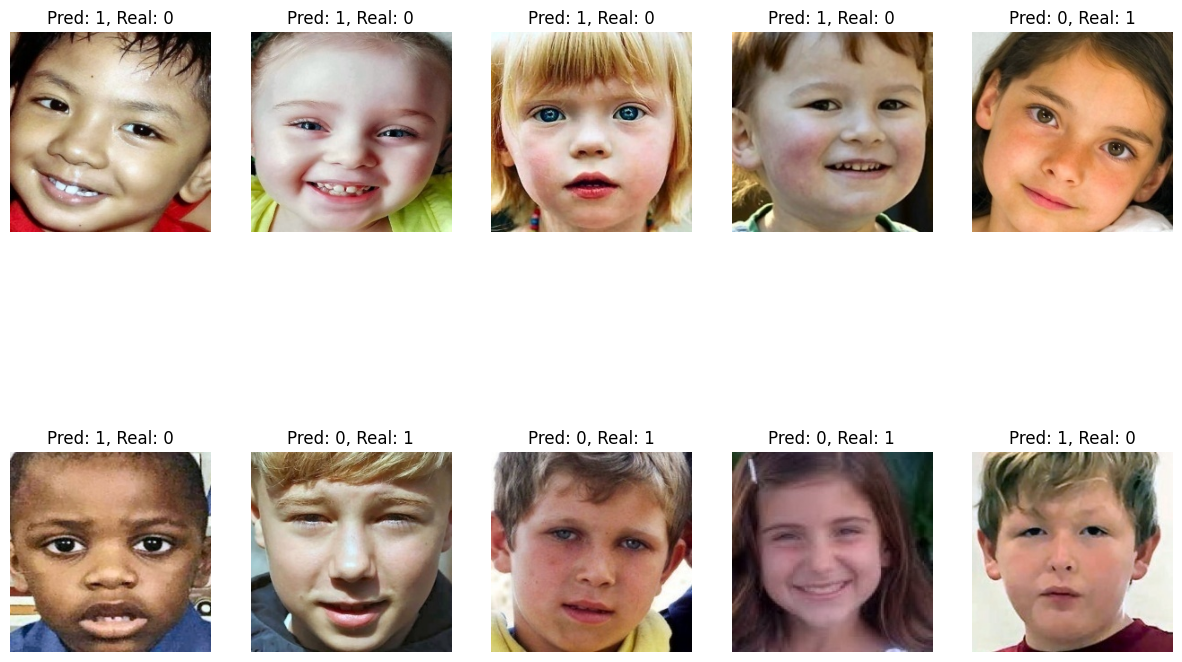

In [36]:
num_imagenes = 10
plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices_incorrectos[:num_imagenes]):
    img = X_test[idx]

    # Convertir de float64 a uint8
    img_uint8 = (img * 255).astype(np.uint8)

    # Convertir de BGR a RGB
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img_rgb)
    plt.title(f"Pred: {predicciones[idx]}, Real: {y_test[idx]}")
    plt.axis('off')

plt.show()

In [37]:
# # Creación del archivo YAML para las arquitecturas de los modelos CNN

# cnn_model_architectures = {
#     "model_binary": {
#         "layers": [
#             {"type": "Conv2D", "output_shape": "(None, 222, 222, 32)", "param_count": 320},
#             {"type": "MaxPooling2D", "output_shape": "(None, 111, 111, 32)", "param_count": 0},
#             {"type": "Conv2D", "output_shape": "(None, 109, 109, 64)", "param_count": 18496},
#             {"type": "MaxPooling2D", "output_shape": "(None, 54, 54, 64)", "param_count": 0},
#             {"type": "Flatten", "output_shape": "(None, 186624)", "param_count": 0},
#             {"type": "Dense", "output_shape": "(None, 64)", "param_count": 11944000},
#             {"type": "Dropout", "output_shape": "(None, 64)", "param_count": 0},
#             {"type": "Dense", "output_shape": "(None, 32)", "param_count": 2080},
#             {"type": "Dropout", "output_shape": "(None, 32)", "param_count": 0},
#             {"type": "Dense", "output_shape": "(None, 1)", "param_count": 33}
#         ],
#         "total_params": 11964929,
#         "trainable_params": 11964929,
#         "non_trainable_params": 0
#     },
#     "best_model_rgb": {
#         "layers": [
#             {"type": "Conv2D", "output_shape": "(None, 222, 222, 32)", "param_count": 896},
#             {"type": "MaxPooling2D", "output_shape": "(None, 111, 111, 32)", "param_count": 0},
#             {"type": "Conv2D", "output_shape": "(None, 109, 109, 64)", "param_count": 18496},
#             {"type": "MaxPooling2D", "output_shape": "(None, 54, 54, 64)", "param_count": 0},
#             {"type": "Flatten", "output_shape": "(None, 186624)", "param_count": 0},
#             {"type": "Dense", "output_shape": "(None, 64)", "param_count": 11944000},
#             {"type": "Dropout", "output_shape": "(None, 64)", "param_count": 0},
#             {"type": "Dense", "output_shape": "(None, 32)", "param_count": 2080},
#             {"type": "Dropout", "output_shape": "(None, 32)", "param_count": 0},
#             {"type": "Dense", "output_shape": "(None, 1)", "param_count": 33}
#         ],
#         "total_params": 11965505,
#         "trainable_params": 11965505,
#         "non_trainable_params": 0
#     }
# }

# # Guardar los datos en un archivo YAML

# with open('cnn_model_architectures', 'w') as file:
#     yaml.dump(cnn_model_architectures, file, default_flow_style=False)



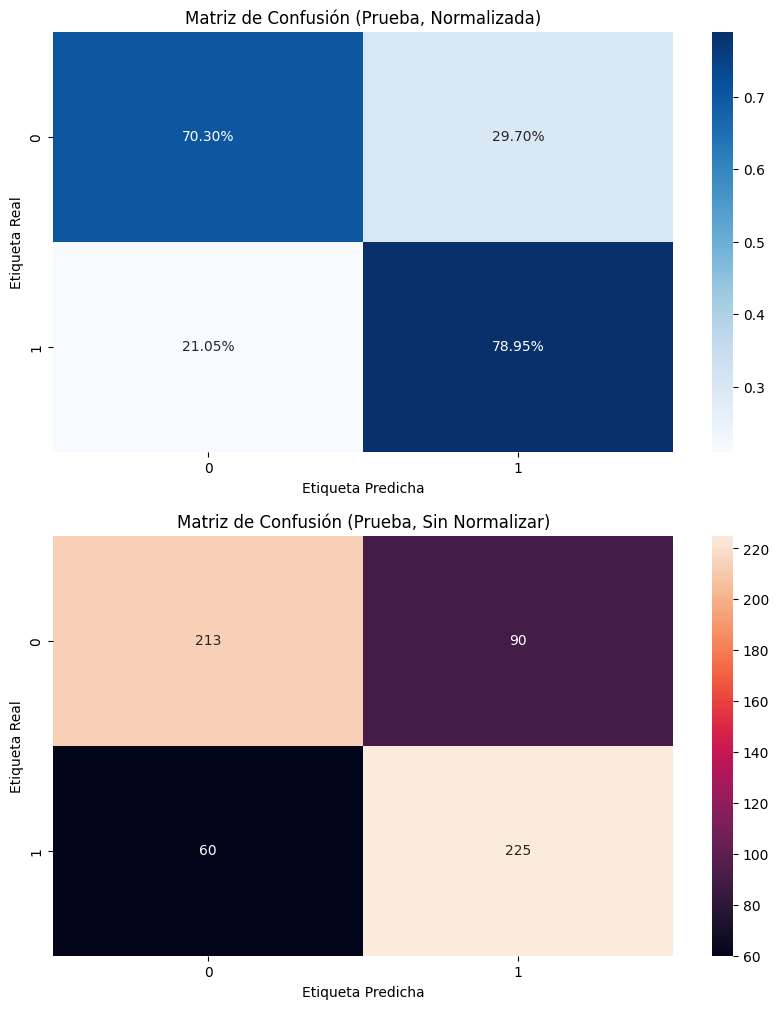

In [38]:
# Configurar subtramas
fig, ax = plt.subplots(2, 1, figsize=(10, 12))  

# Matriz de confusión normalizada
sns.heatmap(confusion_matrix(y_test, predicciones, normalize='true'), annot=True, fmt='.2%', ax=ax[0], cmap='Blues')
ax[0].set_title('Matriz de Confusión (Prueba, Normalizada)')
ax[0].set_ylabel('Etiqueta Real')
ax[0].set_xlabel('Etiqueta Predicha')

# Matriz de confusión sin normalizar
sns.heatmap(confusion_matrix(y_test, predicciones), annot=True, fmt='d', ax=ax[1])
ax[1].set_title('Matriz de Confusión (Prueba, Sin Normalizar)')
ax[1].set_ylabel('Etiqueta Real')
ax[1].set_xlabel('Etiqueta Predicha')

plt.show()